# Lab 17: GPU Computing: Linear Algebra
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22-program/)
#### [Eric Ford](https://www.personal.psu.edu/ebf11)

# Overview
In this lab, you will benchmark some simple operations on a GPU to see how its performance compares to performing the same calculations on a CPU.  While most modern computers have a GPU, not all are designed to support general purpose programming (e.g., most laptop GPUs are optimized for power usage rather than performance).  Additionally, different brands of GPUs provide different programming interfaces.  This lab works with [CUDA-enabled GPUs](https://developer.nvidia.com/cuda-gpus).  During the summer school, we encourage you to use the Amazon servers provided (which have a relatively low-end GPU.)   (These are more expensive, so please be extra careful to shutdown your instance once you're done.)  If you run this lab on your own system (e.g., after the summer school concludes), you'll want to have a CUDA-enabled GPU. 

# Setup 
First, we need to make sure that the packages we'll use are installed on your system.
(The first time you run it, it may take a few minutes to install and pre-compile several packages. 
If so, it will output a long list of packages implicitly used by those packages.  You can ignore the output and scroll down to the next cell.

In [1]:
import Pkg
if isfile("Project.toml")   # Try to save a little time if your Julia environment is already setup
    Pkg.activate("Project.toml")
    try
        using LinearAlgebra, Statistics, Test
        using CUDA
        using BenchmarkTools
        using Plots
    catch
        Pkg.instantiate()
    end
else               
    Pkg.activate(mktempdir())
    Pkg.add([
        Pkg.PackageSpec(name="CUDA", version="3"),
        Pkg.PackageSpec(name="BenchmarkTools", version="1"),
        Pkg.PackageSpec(name="Plots", version="1"),
    ])
end

  Activating project at `~/SummerSchool2022/day5/HighPerformanceComputing`


Next, we import the packages that we'll be using in this notebook.

In [2]:
using LinearAlgebra, Statistics, Test
using CUDA
using BenchmarkTools
using Plots

## Learn about your GPU 
First, we'll verify that we have access to a CUDA-enabled GPU and learn a little about its properties.

In [3]:
CUDA.devices()

CUDA.DeviceIterator() for 1 devices:
0. Tesla T4

If we wanted to check whether our current GPU has some specific capability, then it would be useful to look up it's *compute capability*.

In [4]:
[CUDA.capability(dev) for dev in CUDA.devices()]

1-element Vector{VersionNumber}:
 v"7.5.0"

In principal, we can lookup up the minimum capabilities of all GPUs with that [CUDA compute capability](https://en.wikipedia.org/wiki/CUDA#Version_features_and_specifications).  Alternatively, we can query the GPU about its specific device attributes.   For example, we can check who many multiprocessors are avaliable.

In [5]:
my_gpu_num_multiprocessors = CUDA.attribute(first(devices()), CUDA.DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT)

40

For GPU multiprocessors to acheive their full efficiently, each of those multiprocessors will need to be kept busy with many *threads*.  Work is organized into *blocks* of threads and scheduled in *warps*.  The number of threads in each block can significantly affects the performance.  In order to have a sense of how much work is needed to keep a GPU busy, it's useful to know number of threads in one warp for a given GPU.

In [6]:
my_gpu_warpsize = CUDA.attribute(first(devices()), CUDA.DEVICE_ATTRIBUTE_WARP_SIZE)

32

Later we'll see that for simple calculations, it can take very large problems in order for a GPU to provide a big speed-up factor.  Therefore, an important limitation to keep in mind is the ammount of GPU memory avaliable for storing the input and output data.

In [7]:
my_gpu_ram_gb = (totalmem(first(devices()))) / 1024^3

14.61376953125

# Linear Algebra

First, we'll test and benchmark some basic linear algebra tasks.  
Because linear algebra is so common, there are efficient libraries for baslic linear algebra tasks ([BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)), solving linear systems ([cuSOLVER](https://docs.nvidia.com/cuda/cusolver/index.html)), and even sparse linear algebra ([cuSPARSE](https://docs.nvidia.com/cuda/cusparse/index.html)) avaliable for GPUs.  
Julia's rich type interface allows users to access many of the most common functions by writing the same linear algebra expressions as you would write for vectors and matrices on the CPU, but passing vectors and matrices stored on the GPU.  
(There are also less commonly called library functions which do not have julia wrappers yet, but can be called explicitly.  There's an example at the end of the notebook.)    

Let's create some matrices and arrays on the CPU that we'll use for testing purposes.
                    

In [8]:
N = 4*1024
M = 4*1024

A_h = randn(N,M)
x_h = randn(M);
@time b_h = A_h*x_h;

  0.090347 seconds (303.18 k allocations: 16.856 MiB, 87.24% compilation time)


To perform calculations on a GPU, we'll need to send the data from the CPU to the GPU.  The CUDA pacakge provides a datatype `CuArray` for storing arrays in the GPU or *device* memory.  Manually specifying when to send data back and forth does provide some extra options that be good for efficiency, but it also requires more care.  So instead, we use `CuArray`'s that take care of moving the data between the CPU (or "host") memory system and the GPU (or "device") memory system for us.  
We can create a 'CuArray' from an existing Array simply with the `cu(.)` function.  Then, we can proceed to do arithmetic on them with the same syntax as when using standard Arrays.  (Generic programming is amazing!)

In [43]:
A_d = cu(A_h)
x_d = cu(x_h)
b_d = A_d*x_d;

Let us check the type of each variable.

In [10]:
typeof(A_d), typeof(x_d), typeof(b_d)

(CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 1, CUDA.Mem.DeviceBuffer})

<div class="alert alert-warning">
    Note that the `cu` function decided to convert the data from `Float64` to `Float32`.  This can provide a non-trivial speed-up for GPU calculations, but also increases the risk that floating-point error may lead to unacceptablely inaccurate results.  
We'll want to compare the accuracy of the calculations below.
</div>

By using two CuArray's as input, the result of the calculation is also stored as a CuArray and left on the GPU.  While it is technically possible to access individual elements, it is quite slow.  So when we want to be able to access a whole array, then it will be faster to copy all the data at once to CPU.  We can bring the full result back to the host, using `collect(.)`  Let's compare the two below.


In [45]:
@time CUDA.@allowscalar b_d[1];
@time CUDA.@allowscalar b_d[1];

  0.020706 seconds (6.67 k allocations: 367.655 KiB, 99.40% compilation time)
  0.019528 seconds (6.67 k allocations: 367.655 KiB, 99.43% compilation time)


In [46]:
@time b_comp_h = collect(b_d);
@time b_comp_h = collect(b_d);

  0.000075 seconds (3 allocations: 32.266 KiB)
  0.000071 seconds (3 allocations: 32.266 KiB)


Next, we'll compare the results.  

1a.  What do you expect for the maximum difference in any element in `b_h` and `b_d`?

In [13]:
maximum(abs.(collect(b_d) .- b_h))

7.142982332197789e-5

1b. How did the results compare to your expectations?  

One thing to keep in mind is that most "consumer grade" GPUs are designed to only perform single-precision arithmetic.  Even some GPUs that do support double precission are often significantly slower at double precission arithmetic than single precission.  The difference is particularly noticable for consumer grade GPUs and some recent GPUs optimized for machine learning tasks.  When we want to upload data to the GPU in double precission, we can specify that explicitly.  Below we will reupload our data to the GPU, but this time using double precision on the GPU, so we can test its accuracy.

In [14]:
A_d64 = CuArray{Float64}(A_h)
x_d64 = CuArray{Float64}(x_h)
b_d64 = A_d64*x_d64
maximum(abs.(collect(b_d64) .- b_h))

5.684341886080801e-13

After swtiching to 64-bit floating point arithmetic, how do the results compare to your expectations?  


## Benchmarking GPU for Linear Algebra
Now, we'll do some benchmarking of the CPU vs GPU for basic linear algebra.
Note that we'll be able to use the exact same macros to benchmark code running on either the CPU or the GPU.  To keep things reasonably fast, we'll specify that we only want Julia to benchmark each calculation a few times.  

In [15]:
@benchmark b_h_comp = $A_h*$x_h seconds=1

BenchmarkTools.Trial: 94 samples with 1 evaluation.
 Range (min … max):  10.496 ms …  11.093 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.644 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.676 ms ± 139.139 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▂▂▂ ▂█     ▆▂  ▄▂         ▂                               
  ▆█▄▄███▄███▆█▆▆███▆██▆▄▁▄▆▄▄▁▁█▆▁▁▆▁▄▁▁▄▁▁▁▆▄▁▁▁▄▁▁▁▁▄▁▁▁▁▄▆ ▁
  10.5 ms         Histogram: frequency by time         11.1 ms <

 Memory estimate: 32.05 KiB, allocs estimate: 2.

In [16]:
@benchmark b_d = $A_d*$x_d seconds=1

BenchmarkTools.Trial: 3985 samples with 1 evaluation.
 Range (min … max):    9.483 μs … 418.252 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     284.504 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   248.822 μs ±  93.931 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                            █    
  ▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▂▂▂▄█▃▃ ▂
  9.48 μs          Histogram: frequency by time          297 μs <

 Memory estimate: 176 bytes, allocs estimate: 5.

In [17]:
b_h[1:3], b_d[1:3]

([-54.42039922725253, -45.588190187678826, 71.32435957134041], Float32[-54.4204, -45.588207, 71.32435])

The histogram of the time required on the GPU is likely bimodal.  What could cause that?  Remember, that calls to the GPU run asynchronously.  Sometimes, we timed how long to start the calculation on the GPU and return control to the CPU.  Othertimes, the GPU kernel couldn't start right away because it was still performing work for the last kernel call, so we had to wait for the last kernel to finish before starting the next one.  (It's now possible to launch kernels that use only a fraction of the GPU's multiprocessors, so that multiple kernels are running at once.  But by default, Julia is trying to use all the multiprocessors on the GPU for each calculation.) 
If we want to benchmark how long is required to the calculation to complete, we need to tell Julia to wait until the calculation has been completed with the `CUDA.@sync` macro.  (This can also be very useful for and making sure that there is no risk of variables becoming unsynchronized and overwritten in an order different than we intended.)

In [18]:
@benchmark CUDA.@sync( b_d = $A_d*$x_d) seconds=1

BenchmarkTools.Trial: 134 samples with 1 evaluation.
 Range (min … max):  470.361 μs … 117.717 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):       1.147 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):     7.615 ms ±  16.056 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       ▂                                                      
  █▁▁▁▁▁▁▄█▄▁▁▁▁▁▁▇▇▁▁▁▁▁▁▁▄▄▁▄▄▁▄▁▁▅▄▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▄
  470 μs        Histogram: log(frequency) by time         78 ms <

 Memory estimate: 3.08 KiB, allocs estimate: 53.

1d. Looking at the three above histograms, how long does it take to launch the GPU kernel and return flow control to the CPU, without waiting for the GPU tasks to complete?

1e.  Again looking at the last three histograms, how long did it take to complete the calculation and store to to an array on the GPU?  How does this compare to the cost of launching the kernel?  What are the implications for the ammount of work you'd want per GPU call in order to make efficient use of the GPU?

## Matrix solve

Here, we'll evaluate the speed-up factors for solving a linear system on the GPU, using 32 and 64-bit floating point arithmetic.

In [19]:
solve_for_x_h = A_h \ b_h
walltime_lu_solve_h = @elapsed solve_for_x_h = A_h \ b_h;

In [20]:
CUDA.@sync (solve_for_x_d = A_d \ b_d);
walltime_lu_solve_d = @elapsed (CUDA.@sync solve_for_x_d = A_d \ b_d)
walltime_lu_solve_h / walltime_lu_solve_d

6.271543213852469

In [21]:
CUDA.@sync (solve_for_x_d64 = A_d64 \ b_d64);
walltime_lu_solve_d64 = @elapsed (CUDA.@sync solve_for_x_d64 = A_d64 \ b_d64)
walltime_lu_solve_h / walltime_lu_solve_d64

3.5644730542117533

Let's check to make sure that the GPU results are accurate.

In [22]:
maximum(abs.(A_h \ b_h .- collect(A_d \ b_d)))

0.009108540729629966

In [23]:
maximum(abs.(A_h \ b_h .- collect(A_d64 \ b_d64)))

1.5318704638112024e-11

# Benchmarking vs problem size

As before, the relative efficiency of the CPU and GPU depend on the problem size.  Below, we'll benchmark matrix-vector multiply, matrix-matrix multiply, and solving a linear system as a function of problem size.  

## Matrix-vector multiply

In [48]:
"""
Generate a random matrix (n by m) and a vector (m) and multiply them using the CPU.
Return the time required to multiply them.
"""
function cpu_benchmark_mul_mat_vec(n, m; eltype=Float64)
    A = rand(eltype,n,m)
    x = rand(eltype,m)
    @elapsed b = A*x
end;

In [49]:
"""
Generate a random matrix (n by m) and a vector (m) and multiply them using the GPU.
Return a NamedTuple containing:
- the total time required 
- the time required to initialize the matrices with random values (on the GPU)
- the time required to compute the matrix product
- the time required to transfer the result back to the CPU host
"""
function gpu_benchmark_mul_mat_vec(n,m; eltype=Float64)
    A_d = CUDA.rand(eltype,n,m)
    x_d = CUDA.rand(eltype,m)
    b_d = A_d*x_d
    b_h = collect(b_d)

    time_init = @elapsed CUDA.@sync begin
        A_d = CUDA.rand(eltype,n,m)
        x_d = CUDA.rand(eltype,m)
    end
    time_execute = @elapsed CUDA.@sync begin
        b_d = A_d*x_d
    end
    time_download = @elapsed CUDA.@sync begin
        b_h = collect(b_d)
    end
    time_total = time_init + time_execute + time_download
    return (; time_total, time_init, time_execute, time_download)
end;

In [90]:
n_plot = m_plot = [floor(Int,2^i) for i in 4:0.5:13]   # Size of problems to benchmark

# Benchmark 64-bit floating point arithmetic on GPU device
gpu_mul_mat_vec_64_results = map((n,m)->gpu_benchmark_mul_mat_vec(n,m), n_plot, m_plot)
gpu_mul_mat_vec_64_total = map(x->x.time_total,gpu_mul_mat_vec_64_results)
gpu_mul_mat_vec_64_exec = map(x->x.time_execute,gpu_mul_mat_vec_64_results)

# Benchmark 32-bit floating point arithmetic on GPU device
gpu_mul_mat_vec_32_results = map((n,m)->gpu_benchmark_mul_mat_vec(n,m,eltype=Float32), n_plot, m_plot )
gpu_mul_mat_vec_32_total = map(x->x.time_total,gpu_mul_mat_vec_32_results)
gpu_mul_mat_vec_32_exec = map(x->x.time_execute,gpu_mul_mat_vec_32_results)

# Benchmark 64-bit floating point arithmetic on CPU host
cpu_mul_mat_vec_times_total = map(n->cpu_benchmark_mul_mat_vec(n,n), n_plot );

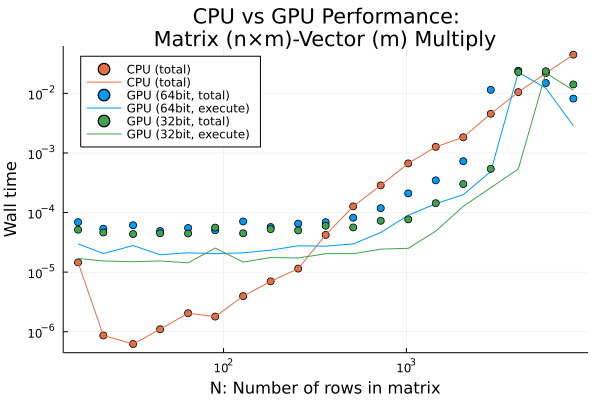

In [91]:
plt = plot(xscale=:log10, yscale=:log10, legend=:topleft);
scatter!(plt, n_plot, cpu_mul_mat_vec_times_total, color=2, label="CPU (total)");
plot!(plt, n_plot, cpu_mul_mat_vec_times_total, color=2, label="CPU (total)");
scatter!(plt, n_plot, gpu_mul_mat_vec_64_total, color=1, label="GPU (64bit, total)");
plot!(plt, n_plot, gpu_mul_mat_vec_64_exec, color=1, label="GPU (64bit, execute)");
scatter!(plt, n_plot, gpu_mul_mat_vec_32_total, color=3, label="GPU (32bit, total)");
plot!(plt, n_plot, gpu_mul_mat_vec_32_exec, color=3, label="GPU (32bit, execute)");
xlabel!(plt, "N: Number of rows in matrix");
ylabel!(plt, "Wall time");
title!(plt,"CPU vs GPU Performance:\nMatrix (n×m)-Vector (m) Multiply");
#savefig("benchmarks_mul_mat_vec.png");
plt

**Question:**  For what size dense matrix-vector multiply, does the runtime of the CPU and GPU become comparable?  

**Question:**  For a favorable use case (problem size, an application where its ok to use 32bit precission, and a case where you do not need to transfer all the data back to the CPU), how much faster is performing the calculation on this GPU than the CPU for matrix-vector multiplies?

## Matrix-Matrix Multiply

In [52]:
"""
Generate two random matrices (n by m) and (m by p) and multiply them using the CPU.
Return the time required to multiply them.
"""
function cpu_benchmark_mul_mat_mat(n, m, p; eltype=Float64)
    A = rand(eltype, n,m)
    x = rand(eltype, m,p)
    @elapsed b = A*x
end;

In [53]:
"""
Generate two random matrices (n by m) and (m by p) and multiply them using the GPU.
Return a NamedTuple containing:
- the total time required 
- the time required to initialize the matrices with random values (on the GPU)
- the time required to compute the matrix product
- the time required to transfer the result back to the CPU host
"""
function gpu_benchmark_mul_mat_mat(n, m, p; eltype=Float64)
    A_d = CUDA.rand(eltype,n,m)
    x_d = CUDA.rand(eltype,m,p)
    b_d = A_d*x_d
    b_h = collect(b_d)

    time_init = @elapsed CUDA.@sync begin
        A_d = CUDA.rand(eltype,n,m)
        x_d = CUDA.rand(eltype,m,p)
    end
    time_execute = @elapsed CUDA.@sync begin
        b_d = A_d*x_d
    end
    time_download = @elapsed CUDA.@sync begin
        b_h = collect(b_d)
    end
    time_total = time_init + time_execute + time_download
    return (; time_total, time_init, time_execute, time_download)
end;

In [54]:
n_plot = m_plot = [2^i for i in 4:12]   # Size of problems to benchmark

# Benchmark 64-bit floating point arithmetic on GPU device
gpu_mul_mat_mat_64_results = map((n,m,p)->gpu_benchmark_mul_mat_mat(n,m ,p), n_plot, m_plot,  n_plot)
gpu_mul_mat_mat_64_total = map(x->x.time_total,gpu_mul_mat_mat_64_results)
gpu_mul_mat_mat_64_exec = map(x->x.time_execute,gpu_mul_mat_mat_64_results)

# Benchmark 32-bit floating point arithmetic on GPU device
gpu_mul_mat_mat_32_results = map((n,m,p)->gpu_benchmark_mul_mat_mat(n,m,p,eltype=Float32), n_plot,m_plot,n_plot )
gpu_mul_mat_mat_32_total = map(x->x.time_total,gpu_mul_mat_mat_32_results)
gpu_mul_mat_mat_32_exec = map(x->x.time_execute,gpu_mul_mat_mat_32_results)

# Benchmark 64-bit floating point arithmetic on CPU host
cpu_mul_mat_mat_times_total = map(n->cpu_benchmark_mul_mat_mat(n,n,n), n_plot );

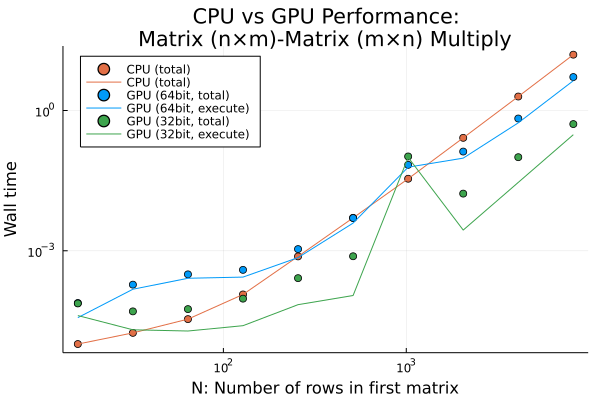

In [55]:
plt = plot(xscale=:log10, yscale=:log10, legend=:topleft);
scatter!(plt, n_plot, cpu_mul_mat_mat_times_total, color=2, label="CPU (total)");
plot!(plt, n_plot, cpu_mul_mat_mat_times_total, color=2, label="CPU (total)");
scatter!(plt, n_plot, gpu_mul_mat_mat_64_total, color=1, label="GPU (64bit, total)");
plot!(plt, n_plot, gpu_mul_mat_mat_64_exec, color=1, label="GPU (64bit, execute)");
scatter!(plt, n_plot, gpu_mul_mat_mat_32_total, color=3, label="GPU (32bit, total)");
plot!(plt, n_plot, gpu_mul_mat_mat_32_exec, color=3, label="GPU (32bit, execute)");
xlabel!(plt, "N: Number of rows in first matrix");
ylabel!(plt, "Wall time");
title!(plt,"CPU vs GPU Performance:\nMatrix (n×m)-Matrix (m×n) Multiply");
#savefig("benchmarks_mul_mat_mat.png");
plt

**Question:**  For what size dense matrix-matrix multiply, does the runtime of the CPU and GPU become comparable?  

**Question:**  Why is the problem size you identified above less than the minimum problem size for this GPU to be faster at matrix-vector multiplies.

**Question:**  For a favorable use case (problem size, an application where its ok to use 32bit precission, and a case where you do not need to transfer all the data back to the CPU), how much faster is performing the calculation on this GPU than the CPU for matrix-matrix multiplies?


## Solving a linear systems of equations

In [56]:
"""
Generate a random matrix A (size n by m) and vector b (size m)
Solve A x = b for x using the CPU.
Return the time required to multiply them.
"""
function cpu_benchmark_lu_solve(n, m; eltype=Float64)
    A = rand(eltype,n,m)
    b = rand(eltype,m)
    @elapsed x = A\b
end

cpu_benchmark_lu_solve

In [57]:
"""
Generate a random matrix A (size n by m) and vector b (size m)
Solve A x = b for x using the GPU.
Return a NamedTuple containing:
- the total time required 
- the time required to initialize the matrices with random values (on the GPU)
- the time required to compute the matrix product
- the time required to transfer the result back to the CPU host
"""
function gpu_benchmark_lu_solve(n, m; eltype=Float64)
    A_d = CUDA.rand(eltype,n,m)
    b_d = CUDA.rand(eltype,m)
    x_d = A_d \ b_d
    x_h = collect(x_d)

    time_init = @elapsed CUDA.@sync begin
        A_d = CUDA.rand(eltype,n,m)
        b_d = CUDA.rand(eltype,m)
    end
    time_execute = @elapsed CUDA.@sync begin
        x_d = A_d\b_d
    end
    time_download = @elapsed CUDA.@sync begin
        x_h = collect(x_d)
    end
    time_total = time_init + time_execute + time_download
    return (; time_total, time_init, time_execute, time_download)
end

gpu_benchmark_lu_solve

In [59]:
n_plot = m_plot = [2^i for i in 4:12]   # Size of problems to benchmark

# Benchmark 64-bit floating point arithmetic on GPU device
gpu_solve_64_results = map(n->gpu_benchmark_lu_solve(n,n), n_plot)
gpu_solve_64_total = map(x->x.time_total,gpu_solve_64_results)
gpu_solve_64_exec = map(x->x.time_execute,gpu_solve_64_results)

# Benchmark 32-bit floating point arithmetic on GPU device
gpu_solve_32_results = map(n->gpu_benchmark_lu_solve(n,n,eltype=Float32), n_plot )
gpu_solve_32_total = map(x->x.time_total,gpu_solve_32_results)
gpu_solve_32_exec = map(x->x.time_execute,gpu_solve_32_results)

# Benchmark 64-bit floating point arithmetic on CPU host
cpu_solve_times_total = map(n->cpu_benchmark_lu_solve(n,n), n_plot );

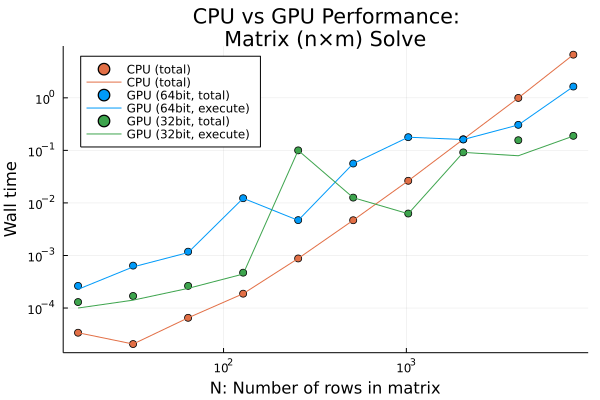

In [60]:
plt = plot(xscale=:log10, yscale=:log10, legend=:topleft);
scatter!(plt, n_plot, cpu_solve_times_total, color=2, label="CPU (total)");
plot!(plt, n_plot, cpu_solve_times_total, color=2, label="CPU (total)");
scatter!(plt, n_plot, gpu_solve_64_total, color=1, label="GPU (64bit, total)");
plot!(plt, n_plot, gpu_solve_64_exec, color=1, label="GPU (64bit, execute)");
scatter!(plt, n_plot, gpu_solve_32_total, color=3, label="GPU (32bit, total)");
plot!(plt, n_plot, gpu_solve_32_exec, color=3, label="GPU (32bit, execute)");
xlabel!(plt, "N: Number of rows in matrix");
ylabel!(plt, "Wall time");
title!(plt,"CPU vs GPU Performance:\nMatrix (n×m) Solve");
#savefig("benchmarks_solve.png");
plt

**Question:**  When solving a dense $n$ by $n$ system of equations, for what size dense matrix-matrix multiply, does the runtime of the CPU and GPU become comparable?  

**Question:**  For a favorable use case (problem size, an application where its ok to use 32bit precission, and a case where you do not need to transfer all the data back to the CPU), how much faster is performing the calculation on this GPU than the CPU for solving a dense set of equations via LU factorization?
does the runtime of the CPU and GPU become comparable?  

**Question:**  Why is the speed-up for solving a linear system not as extreme as for matrix-matrix multiply (for the same problem size and a favorable use case)?

## Next steps

## Additional considerations for Optimizing GPU Performance (optional)
We've seen that often a GPUs throughput can limited by the time required to transfer data.
To help reduce the cost of memory transfers, the GPU has its own memory *cache*.  
Acheiving very high performance on a GPU often requires implementations being optimized for the size of the *GPU's L2 cache*.  
For common operations like linear algebra, this will happen behind the scenes for us.  

In [62]:
my_gpu_L2_cache_mb = CUDA.attribute(first(devices()), CUDA.DEVICE_ATTRIBUTE_L2_CACHE_SIZE) / 1024^2

4.0

**Question:** For what problem sizes will the data in our benchmarks above start to overflow the L2 cache size of this GPU?  

**Question:** Do you notice any features in the benchmarking results around this problem size?  (You may need to rerun benchmarks several times to see which features are "real" and which are "noise".)

### Example of batched linear algebra operations on GPU (optional)

It's also possible to perform many small linear algebra operations efficiently on the GPU.  Unfortunately, this requires diving into the documentation for CUDA and its associated libraries.  In case you're interested, here's an example.  To find other batched functions or to make sense of the outputs, you'll want to look at the documentation for [CUBLAS](https://docs.nvidia.com/cuda/cublas/index.html), the library of CUDA functions that provide these operations.  For some problem sizes, the CUBLAS functions are very efficient.  For other problem sizes, you can work more efficiently using multiple asyncrhonous kernel calls or just using multi-threading on the CPU. 

In [96]:
# Example of calling function from CUBLAS for batched linear algebra operations.
let
    elty = Float64
    num_systems = 500
    n = 40
    k = 1
    # generate matrices
    A = [ begin
            R = rand(elty,n,n)
            Q = R'*R
            (Q'+Q)/2
        end for i in 1:num_systems]
    x = [rand(elty,n,k) for i in 1:num_systems]
    b = [ A[i]*x[i] for i in 1:num_systems]

    # move to device
    local d_A = CuArray{elty, 2}[]
    local d_A_in = CuArray{elty, 2}[]
    local d_b = CuArray{elty, 2}[]
    for i in 1:length(A)
       push!(d_A,CuArray(A[i]))
       push!(d_A_in,copy(d_A[i]))
       push!(d_b,CuArray(b[i]))
    end
    output_qr_d, output_x_d, output_flag_d = CUBLAS.gels_batched('N', d_A, d_b)
    @test all(collect(output_flag_d).==0)  # Test solve suceeded
    @test all([all(isapprox.(x[i], collect(collect(output_x_d)[i]), rtol=1e-2)) for i in 1:num_systems]);
end

Test Passed
  Expression: all([all(isapprox.(x[i], collect((collect(output_x_d))[i]), rtol = 0.01)) for i = 1:num_systems])